# Life Expectancy Prediction Project

I will use the **Life Expectancy dataset**, collected by the WHO and the United Nations, assembled and available at: https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who. I will train a regression model to predict the life expectancy of a country based on the time series data of the same or different countries. The columns of the dataset are:

* **Life expectancy:** measured in years (target variable)
* **Country**
* **Year**
* **Status:** developing or developed country
* **Population:** population of the country
* **Adult mortality:** number of deaths of adults per 1000 population, for both sexes
* **Infant deaths:** number of infant deaths per 1000 population
* **Under-five deaths:** number of under-five deaths per 1000 population
* **GDP:** Gross Domestic Product per capita (in USD)
* **Percentage expenditure:** expenditure on health as a percentage of Gross Domestic Product per capita (%)
* **Total expenditure:** general government expenditure on health as a percentage of total government expenditure (%)
* **Income composition:** Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
* **Hepatitis B:** hepatitis B (HepB) immunization coverage among 1-year-olds (%)
* **Polio:** polio (Pol3) immunization coverage among 1-year-olds (%)
* **Diphteria:** Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
* **Measles:** number of reported cases per 1000 population
* **HIV/AIDS:** deaths per 1000 live births HIV/AIDS (0-4 years)
* **Thinness 5-9:** prevalence of thinness among children and adolescents for age 5 to 9 (%)
* **Thinness 10-19:** prevalence of thinness among children and adolescents for age 10 to 19 (%)
* **BMI:** average Body Mass Index of entire population
* **Alcohol:** recorded per capita (15+) consumption (in litres of pure alcohol)
* **Schooling:** number of years of schooling

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
np.set_printoptions(legacy='1.25')

import plotly.io as pio
pio.templates.default = 'simple_white'
pio.renderers.default = 'png'
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [2]:
df = pd.read_csv('life_expectancy_data.csv')
df

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


# Inititial exploratory data analysis

In [3]:
# Formatting column names:
df.columns = df.columns.str.lower().str.strip()
df.columns = df.columns.str.replace(' ', '_').str.replace('__', '_').str.replace('/', '_')
df = df.rename(columns={'thinness_1-19_years': 'thinness_10-19_years'})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   hepatitis_b                      2385 non-null   float64
 9   measles                          2938 non-null   int64  
 10  bmi                              2904 non-null   float64
 11  under-five_deaths                2938 non-null   int64  
 12  polio               

The target variable `life_expectancy` has 10 missing values, so these rows will be removed:

In [5]:
df.dropna(subset=['life_expectancy'],how='any',inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
# Check if there are duplicated data:
df.duplicated().any()

False

In [7]:
cols_numerical = df.select_dtypes(include=['int64', 'float64']).columns
cols_categorical = df.select_dtypes(include=['object']).columns

In [8]:
# Value counts of categorical data:
for col in cols_categorical:
    print('Number of unique values of', col, ':', df[col].nunique())
    value_counts = df[col].value_counts()
    print(value_counts.value_counts())
    print()

Number of unique values of country : 183
count
16    183
Name: count, dtype: int64

Number of unique values of status : 2
count
2416    1
512     1
Name: count, dtype: int64



In [9]:
# Summary stats of numerical data:
df.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

,count,mean,std,min,25%,50%,75%,max
year,2928.00,2007.50,4.61,2000.00,2003.75,2007.50,2011.25,2015.00
life_expectancy,2928.00,69.22,9.52,36.30,63.10,72.10,75.70,89.00
adult_mortality,2928.00,164.80,124.29,1.00,74.00,144.00,228.00,723.00
infant_deaths,2928.00,30.41,118.11,0.00,0.00,3.00,22.00,1800.00
alcohol,2735.00,4.61,4.05,0.01,0.91,3.77,7.71,17.87
percentage_expenditure,2928.00,740.32,1990.93,0.00,4.85,65.61,442.61,19479.91
hepatitis_b,2375.00,80.96,25.02,1.00,77.00,92.00,97.00,99.00
measles,2928.00,2427.86,11485.97,0.00,0.00,17.00,362.25,212183.00
bmi,2896.00,38.24,19.96,1.00,19.30,43.35,56.10,77.60
under-five_deaths,2928.00,42.18,160.70,0.00,0.00,4.00,28.00,2500.00


When inspecting the summary stats and histograms, several columns had odd or peculiar data:

* Each of the 16 years contains the same number of values, meaning the 10 rows with missing values of `life_expectancy` that were deleted earlier had data for 10 different countries than the ones left in `df`. This will not affect posterior analyses.
* `infant_deaths`, `under-five_deaths` and `measles` contains values >1000.
* `population` showed values as low as 34 and as high as 1.3 billion.
* `percentage_expenditure` does not cointain values between 0-1 or 0-100 (percentages).
* `income_composition_of_resources` contains many 0 values, which could represent missing values, as there is a gap of values >0 and <0.25.
* `bmi` shows values unrealistically low (<<<18.5) or high (>>>39.9), outside of the natural ranges of BMI.

We'll have a deeper look into some of these columns:

### Infant deaths, under-five deaths and measles

Such high values (>1000) could indicate cases were not normalized per 1000 population.

In [10]:
(df.loc[:, 'infant_deaths'] > 1000).sum(), (df.loc[:, 'under-five_deaths'] > 1000).sum(), (df.loc[:, 'measles'] > 1000).sum()

(13, 16, 525)

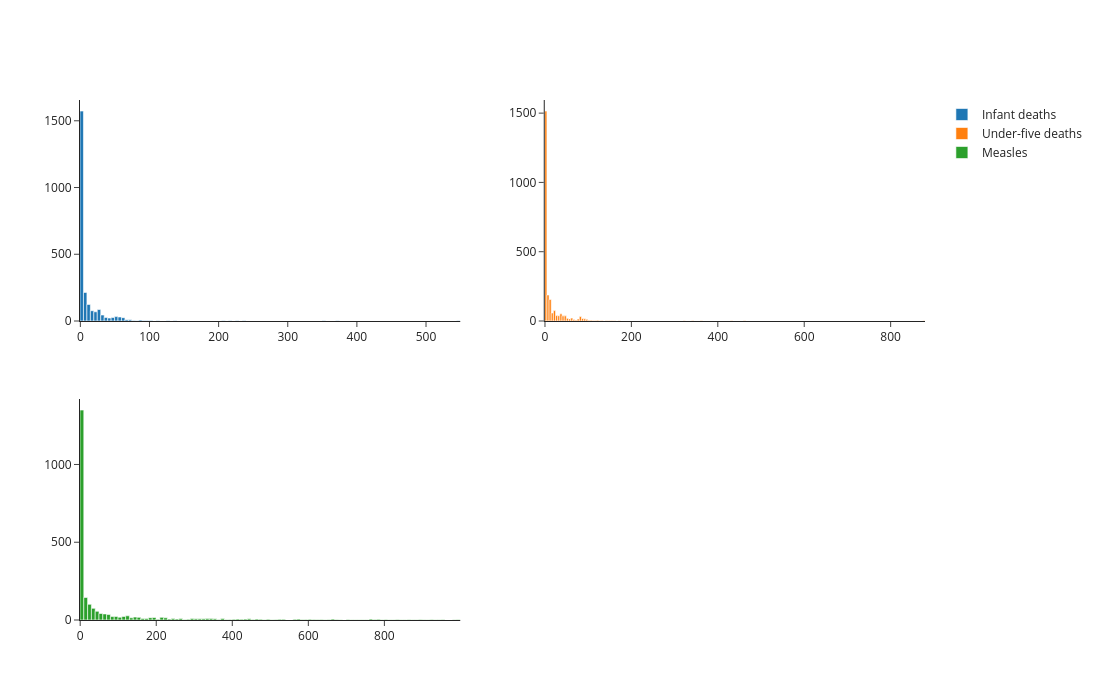

In [11]:
df_inf_deaths_measles_less1000 = df.loc[(df.loc[:, 'infant_deaths'] < 1000) & 
                                        (df.loc[:, 'under-five_deaths'] < 1000) & 
                                        (df.loc[:, 'measles'] < 1000)]

fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Histogram(x=df_inf_deaths_measles_less1000['infant_deaths'], name='Infant deaths'),
             row=1, col=1)
fig.add_trace(go.Histogram(x=df_inf_deaths_measles_less1000['under-five_deaths'], name='Under-five deaths'),
             row=1, col=2)
fig.add_trace(go.Histogram(x=df_inf_deaths_measles_less1000['measles'], nbinsx=100, name='Measles'),
             row=2, col=1)

fig.update_layout(height=700, width=1100)
fig.show()

In the case of `infant_deaths` and `under-five_deaths`, only 13 and 16 examples have values >1000, indicating data might actually be normalized by population. The histograms for both columns look okay, with the higher-frequency values being around 0-4. However, I performed a quick search at https://childmortality.org/ for a variety of countries and found that values for both columns mostly did not match the values in the database. In case the values in this dataset are not correct, I will replace them by the UN IGME estimates for infant mortality, under-five mortality and neonatal mortality rates. The dataset is downloaded from https://childmortality.org/all-cause-mortality/data/download?indicator=MRY0T4&refArea=AFG as `UNICEF-CME_DF_2021_WQ-1.0-download.csv`.

In [12]:
df_children = pd.read_csv('UNICEF-CME_DF_2021_WQ-1.0-download.csv',
                          usecols=['Geographic area', 'Indicator', 'Series Name', 'TIME_PERIOD', 'OBS_VALUE'])

# Renaming columns to match the columns of df:
df_children = df_children.rename(columns={'Geographic area': 'country', 'Series Name': 'series_name', 'TIME_PERIOD': 'year'})
# Subsetting only UN IGME estimate values
df_children = df_children.loc[df_children.loc[:, 'series_name'] == 'UN IGME estimate']
df_children.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39675 entries, 15 to 91608
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      39675 non-null  object 
 1   Indicator    39675 non-null  object 
 2   series_name  39675 non-null  object 
 3   year         39675 non-null  object 
 4   OBS_VALUE    39675 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.8+ MB


In [13]:
# Subsetting only rows of years 2000-2015:
df_children['year'] = df_children['year'].str.replace('-06', '')
years = list(range(2000, 2016))
df_children['year'] = df_children['year'].astype(int)
df_children = df_children.loc[df_children['year'].isin(years)]

In [14]:
# Table pivot to obtain the indicators as columns:
df_children_pivot = df_children.pivot_table(index=['country', 'year'], 
                                   columns='Indicator', 
                                   values='OBS_VALUE').reset_index()
df_children_pivot.columns = ['country', 'year', 'infant_mortality_rate', 'neonatal_mortality_rate', 'under-five_mortality_rate']
df_children_pivot

,country,year,infant_mortality_rate,neonatal_mortality_rate,under-five_mortality_rate
0,Afghanistan,2000,92.010106,62.693351,131.639217
1,Afghanistan,2001,89.322969,61.482939,127.371223
2,Afghanistan,2002,86.571870,60.209191,123.022248
3,Afghanistan,2003,83.715381,58.884175,118.508077
4,Afghanistan,2004,80.885684,57.472937,114.038248
...,...,...,...,...,...
3755,Zimbabwe,2011,51.067659,31.087776,79.986703
3756,Zimbabwe,2012,46.802387,30.089620,71.744139
3757,Zimbabwe,2013,44.955179,29.178977,65.881488
3758,Zimbabwe,2014,43.024039,28.478751,62.290730


In [15]:
# Number of matching countries between both dfs:
unique_countries_df = df['country'].unique()
unique_countries_df_children_pivot = df_children_pivot['country'].unique()
len(np.intersect1d(unique_countries_df, unique_countries_df_children_pivot))

179

In [16]:
# Countries unique to df:
np.setdiff1d(unique_countries_df, unique_countries_df_children_pivot)

array(['Netherlands', 'Swaziland',
       'The former Yugoslav republic of Macedonia', 'Turkey'],
      dtype=object)

Searching these countries in childmortality.org, I see the names are recorded as: Netherlands (Kingdom of the), Eswatini (former Swaziland), North Macedonia and The Republic of Türkiye.

In [17]:
df_children_pivot['country'] = df_children_pivot['country'].str.replace('Netherlands (Kingdom of the)', 'Netherlands')
df_children_pivot['country'] = df_children_pivot['country'].str.replace('Eswatini', 'Swaziland')
df_children_pivot['country'] = df_children_pivot['country'].str.replace('North Macedonia', 'The former Yugoslav republic of Macedonia')
df_children_pivot['country'] = df_children_pivot['country'].str.replace('The Republic of Türkiye', 'Turkey')

In [18]:
df_merged = df.merge(df_children_pivot, on=['country', 'year'])
df_merged['country'].nunique()

183

In the case of `measles`, 525 records show values >1000. In the case values were not normalized by 1000 population, one could expect to see min values substantially greater than zero. For reference, in a developed country like Spain, there were 0.3 reported cases of measles per 100,000 population in 2014 (source: https://www.sanidad.gob.es/). However, the majority of records took values between 0-9, making this column unreliable. Thus, I will leave out this column for training.

### Population

There are many examples with low population values, being 34 the minimum.

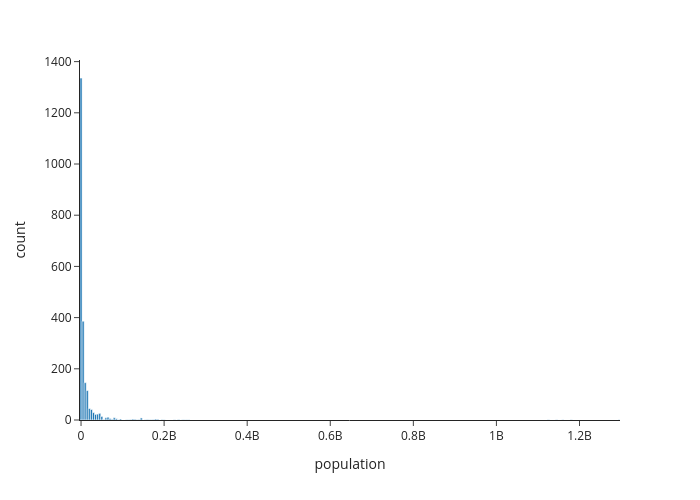

In [19]:
fig = px.histogram(df, x='population', nbins=500)
fig.show()

I search online the top smallest countries in the world and looked for their population values on the dataset (source: https://bestdiplomats.org/countries-with-lowest-population/):

In [20]:
smallest_countries = ['Vatican City', 'Tuvalu', 'Nauru', 'Palau', 'San Marino', 'Monaco', 'Liechtenstein', 
                      'Saint Kitts and Nevis', 'Dominica', 'Andorra', 'Tonga', 'Seychelles', 'Antigua and Barbuda', 
                      'Micronesia', 'Saint Vincent and the Grenadines']
df_smallest_countries = df[df['country'].isin(smallest_countries)]
df_smallest_countries['population'].describe()

count       32.000000
mean     44066.812500
std      40782.577549
min        135.000000
25%       8941.000000
50%      15555.000000
75%      87041.500000
max      99789.000000
Name: population, dtype: float64

In [21]:
df_smallest_countries.loc[df_smallest_countries.loc[:, 'population'] == 135]

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
2631,Tonga,2008,Developing,72.6,145.0,0,1.1,569.625504,84.0,0,...,88.0,5.13,86.0,0.1,3392.64743,135.0,0.1,0.1,0.698,14.5


In [22]:
((df.loc[:, 'population'] >= 34) & (df.loc[:, 'population'] <= 135)).sum()

6

The smallest country according to the dataset was Tonga, which is not among the smallest countries list (and actually amounted for a total 107,000 in 2014, source: Google). Furthermore, 5 additional examples in the dataset had population values <135. Therefore, the `population` column is highly unreliable and will be excluded for training.

### Percentage of expenditure

The column does not cointain percentages, thus it may not be corrected by GDP. However, the most frequent values are close to zero, which is most probably impossible:

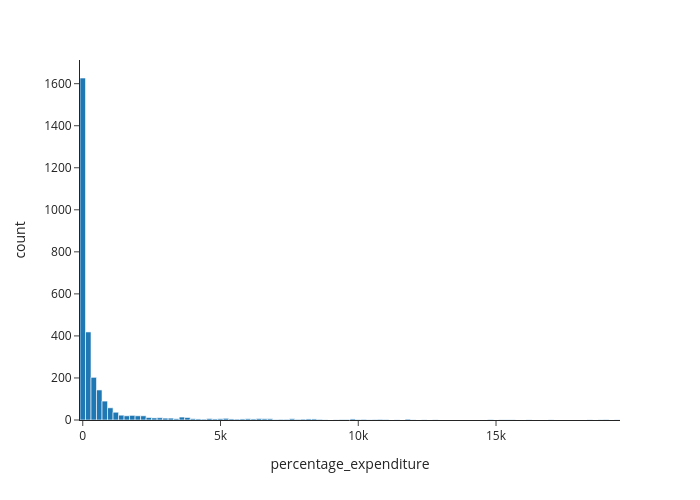

In [23]:
fig = px.histogram(df, x='percentage_expenditure')
fig.show()

In [24]:
(df.loc[:, 'percentage_expenditure'] > 100).sum() / df.shape[0] * 100

44.43306010928962

Moreover, >44% of examples have values >100, indicating this column is not reliable either. However, column `total_expenditure` seems to contain plausible values (percentages) and provides similar information as `percentage_expenditure`. Thus, training will be performed only with `total_expenditure`.

### BMI

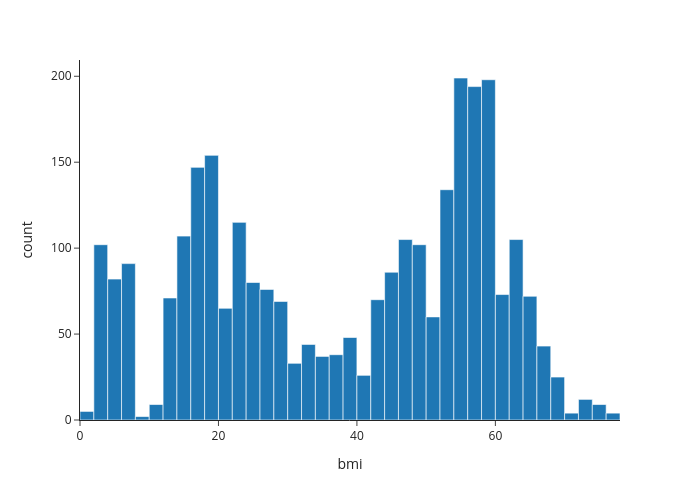

In [25]:
fig = px.histogram(df, x='bmi')
fig.show()

In [26]:
df_low_bmi = df.loc[df.loc[:, 'bmi'] < 18]
df_high_bmi = df.loc[df.loc[:, 'bmi'] > 40]
df_low_bmi['status'].value_counts(), df_high_bmi['status'].value_counts()

(status
 Developing    565
 Developed      51
 Name: count, dtype: int64,
 status
 Developing    1089
 Developed      432
 Name: count, dtype: int64)

Many developed countries (n=51) would have average BMI considered as underweight. On the other hand, many developing countries (n=1096) would have average BMI in the range of morbid obesity. This values are obviously not realistic, so I will drop them for further analysis.

# Initial correlation matrix

First, I will subset the columns I decided to keep after the initial EDA. Notice that the `country` column is no longer included, since I will train a general model to predict the life expectancy of a given country.

In [27]:
cols_to_keep = ['year', 'status', 'life_expectancy',
                'adult_mortality', 'infant_mortality_rate', 'under-five_mortality_rate', 'neonatal_mortality_rate',
                'gdp', 'total_expenditure', 'income_composition_of_resources',
                'hepatitis_b', 'polio', 'diphtheria', 'hiv_aids', 'thinness_5-9_years', 'thinness_10-19_years',
                'alcohol', 'schooling']
df_keep = df_merged[cols_to_keep]
df_keep

,year,status,life_expectancy,adult_mortality,infant_mortality_rate,under-five_mortality_rate,neonatal_mortality_rate,gdp,total_expenditure,income_composition_of_resources,hepatitis_b,polio,diphtheria,hiv_aids,thinness_5-9_years,thinness_10-19_years,alcohol,schooling
0,2015,Developing,65.0,263.0,54.587315,72.676981,42.363969,584.259210,8.16,0.479,65.0,6.0,65.0,0.1,17.3,17.2,0.01,10.1
1,2014,Developing,59.9,271.0,56.242054,75.282730,43.507852,612.696514,8.18,0.476,62.0,58.0,62.0,0.1,17.5,17.5,0.01,10.0
2,2013,Developing,59.9,268.0,58.069948,78.159978,44.701171,631.744976,8.13,0.470,64.0,62.0,64.0,0.1,17.7,17.7,0.01,9.9
3,2012,Developing,59.5,272.0,60.091018,81.340676,45.988517,669.959000,8.52,0.463,67.0,67.0,67.0,0.1,18.0,17.9,0.01,9.8
4,2011,Developing,59.2,275.0,62.257073,84.738789,47.322593,63.537231,7.87,0.454,68.0,68.0,68.0,0.1,18.2,18.2,0.01,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,2004,Developing,44.3,723.0,51.631593,90.473104,30.800916,454.366654,7.13,0.407,68.0,67.0,65.0,33.6,9.4,9.4,4.36,9.2
2924,2003,Developing,44.5,715.0,50.527621,90.266143,29.860859,453.351155,6.52,0.418,7.0,7.0,68.0,36.7,9.9,9.8,4.06,9.5
2925,2002,Developing,44.8,73.0,50.527382,91.225726,28.738312,57.348340,6.53,0.427,73.0,73.0,71.0,39.8,1.3,1.2,4.43,10.0
2926,2001,Developing,45.3,686.0,50.670455,92.528774,27.540166,548.587312,6.16,0.427,76.0,76.0,75.0,42.1,1.7,1.6,1.72,9.8


In [28]:
cols_numerical = df_keep.select_dtypes(include=['int64', 'float64']).columns
df_numerical = df_keep.loc[:, cols_numerical]
corr_matrix = df_numerical.corr()

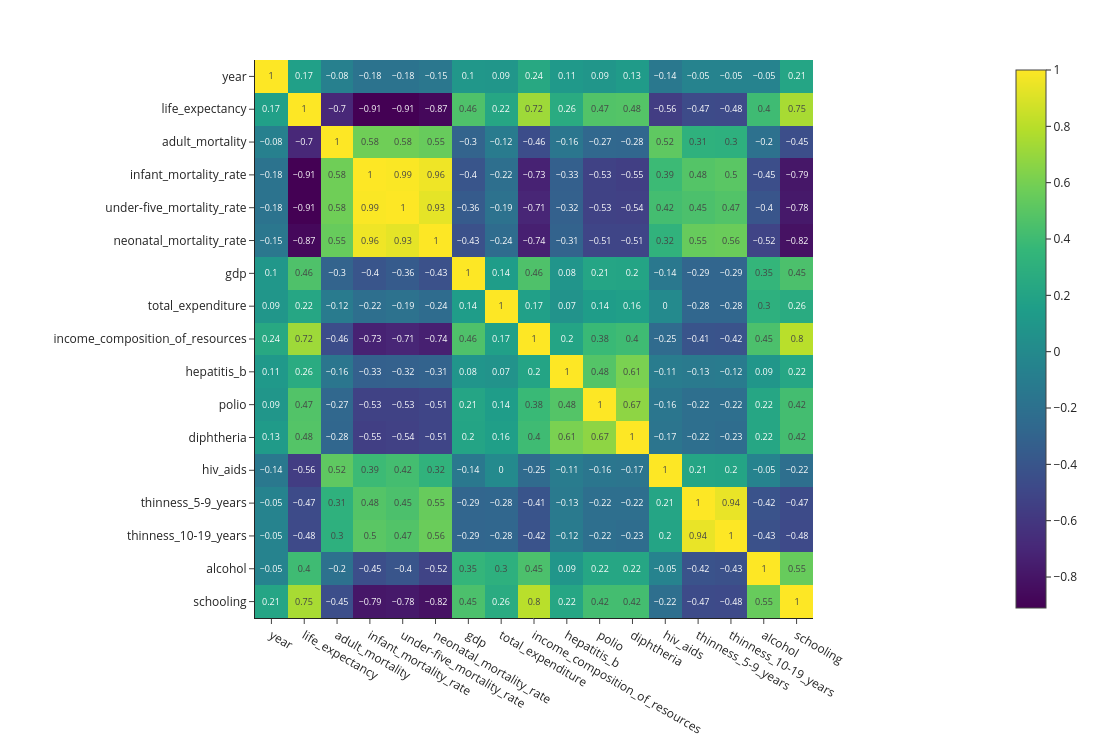

In [29]:
fig = px.imshow(corr_matrix.round(2), text_auto=True)
fig.update_layout(height=750, width=1100)
fig.show()

Since the three features `infant_mortality_rate`, `under-five_mortality_rate` and `neonatal_mortality_rate` are highly correlated with `life_expectancy` and with each other, I will only keep one feature: `infant_mortality_rate`, as it is more general.

In [30]:
df_keep = df_keep.drop(columns=['under-five_mortality_rate', 'neonatal_mortality_rate'])

# Exploring missing values

The feature `income_composition_of_resources` has several rows with 0s (appart from NaNs) that probably represent missing values. First, I'm going to convert these 0s to NaNs.

In [31]:
df_keep['income_composition_of_resources'] = df_keep['income_composition_of_resources'].replace(0, np.nan)

In [32]:
df_keep.isnull().sum()

year                                 0
status                               0
life_expectancy                      0
adult_mortality                      0
infant_mortality_rate                0
gdp                                443
total_expenditure                  226
income_composition_of_resources    290
hepatitis_b                        553
polio                               19
diphtheria                          19
hiv_aids                             0
thinness_5-9_years                  32
thinness_10-19_years                32
alcohol                            193
schooling                          160
dtype: int64

Let's investigate the distribution of missing values further:

<Axes: >

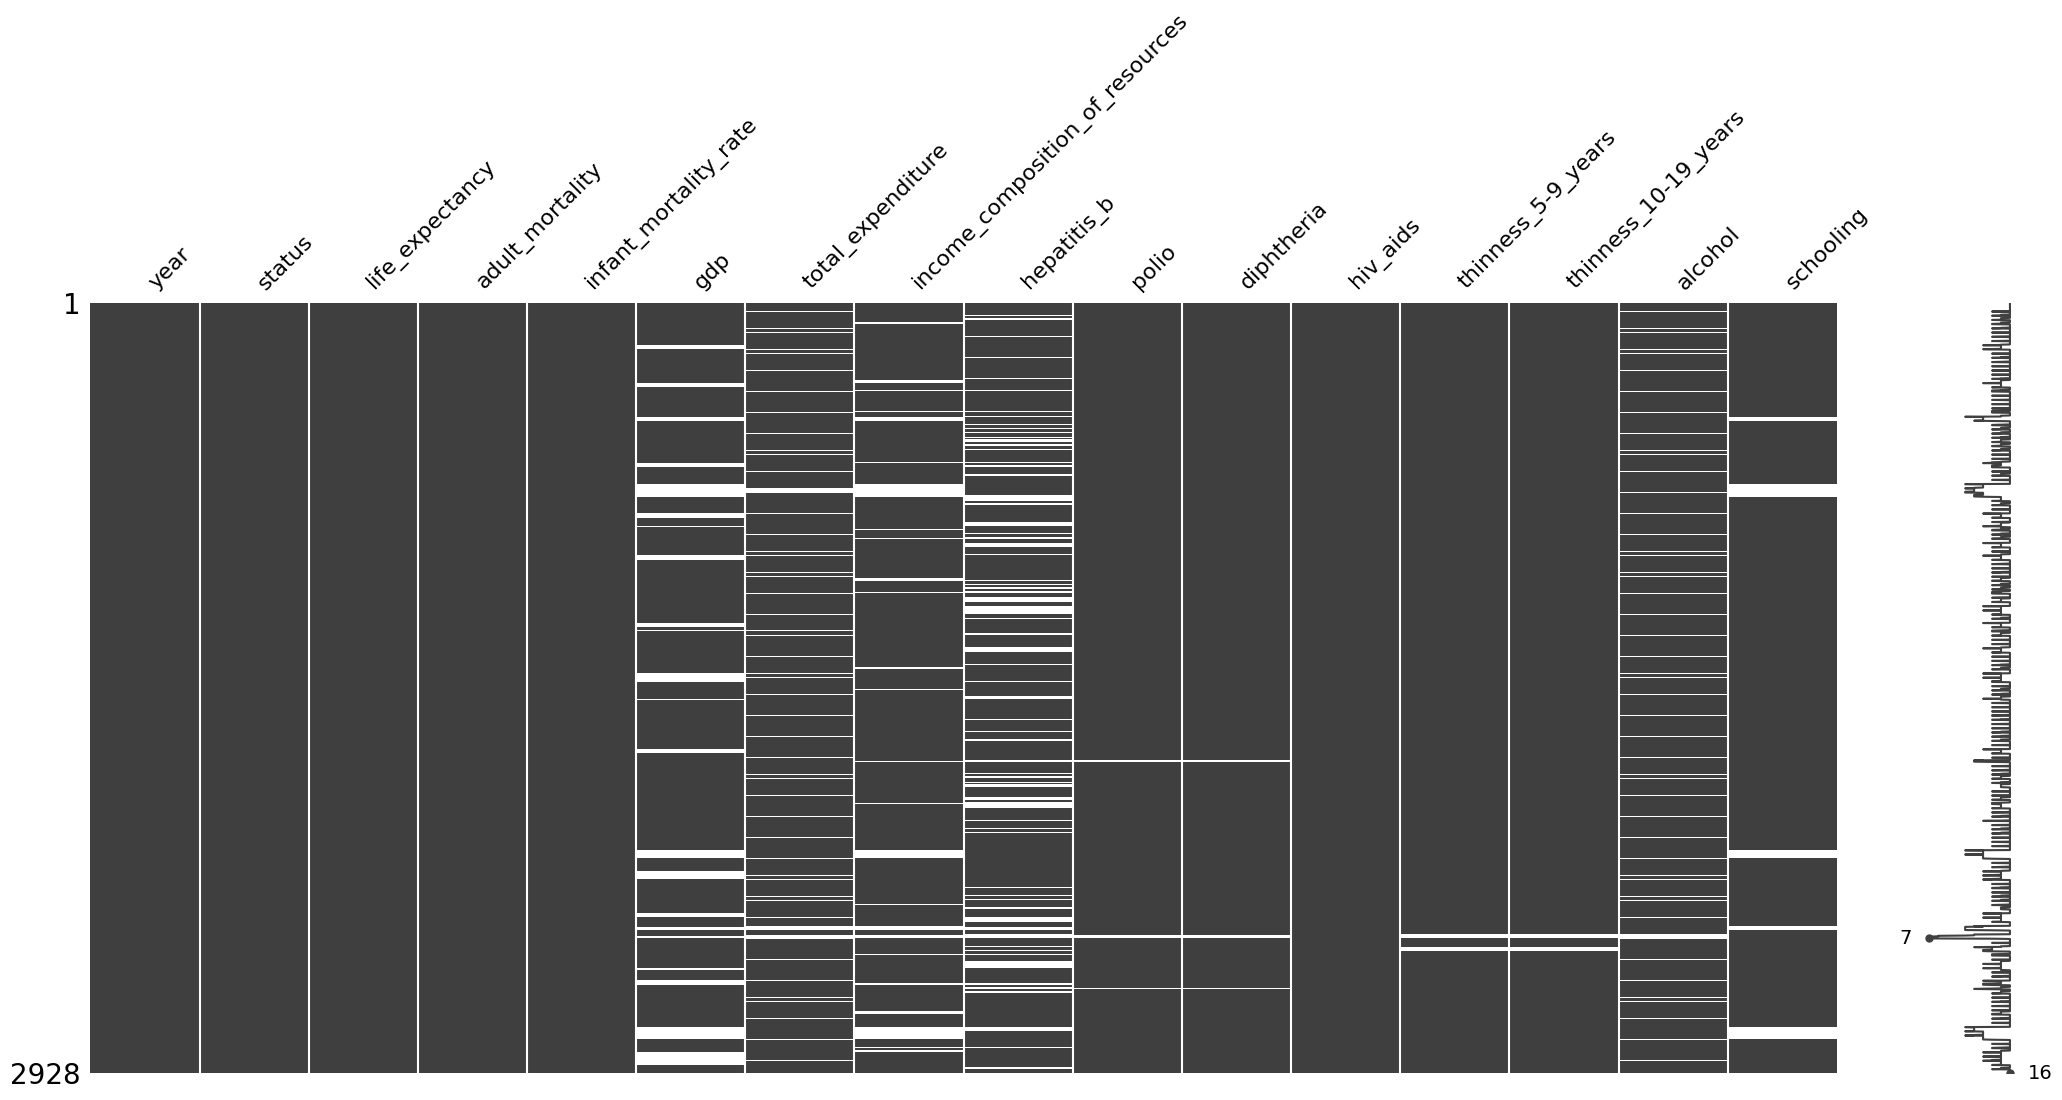

In [33]:
msno.matrix(df_keep)

<Axes: >

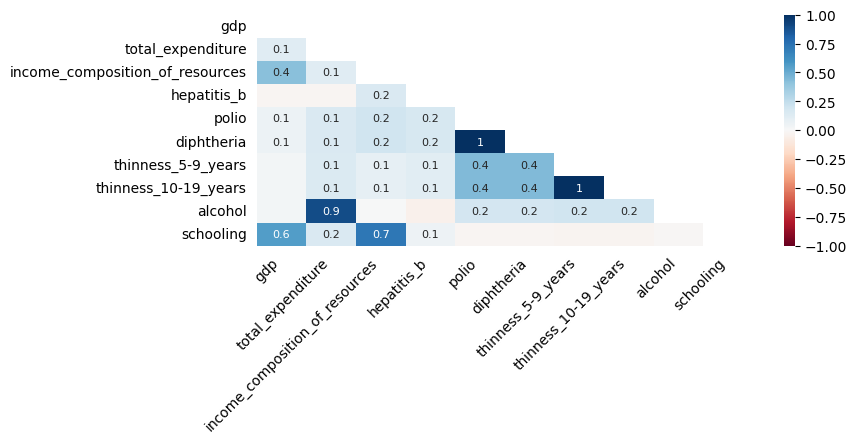

In [34]:
msno.heatmap(df_keep, figsize=(8,3), fontsize=10)

<Axes: >

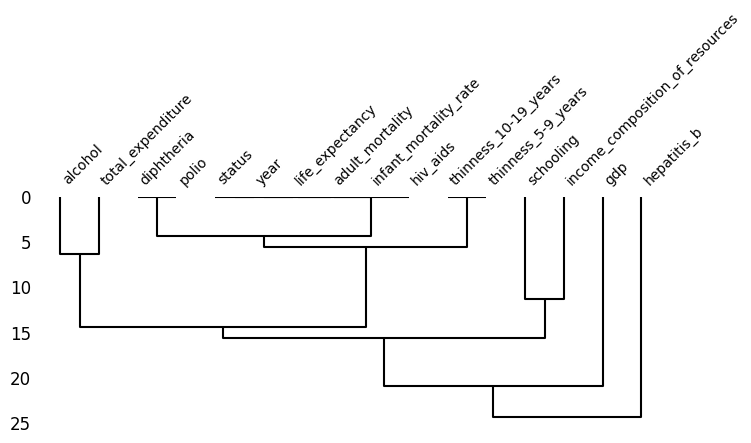

In [35]:
msno.dendrogram(df_keep, figsize=(8,3), fontsize=10)

Missingness of features `diphteria`-`polio`, `thinness_5-9_years`-`thinness_10-19_years`, `alcohol`-`total_expenditure` and `schooling`-`income_composition_of_resources` are highly correlated pairwise (R > 0.7), and thus seem to be missing at random (MAR). The missingness of `gdp` could be missing not at random (MNAR) due to the distribution of NaNs, although it seems to be weakly correlated with `income_composition_of_resources` and `schooling` (R = 0.6), indicating it could be MAR. Feature `hepatitis_b` could be MNAR due to lack of correlation with the missingness of any other feature. Thus, and given its low correlation with the target variable (R = 0.26), I will drop this column from further analysis. For the remaining features with NaNs, for simplicity and to avoid dropping the `gdp` feature, I'm going to assume the values are MAR and proceed with an imputation technique.

In [36]:
df_keep = df_keep.drop('hepatitis_b', axis=1)

# Dataset splitting and one-hot encoding

Since I'm working with a time series dataset, I will extract the rows of the latest 3 years (2013-2015, ~20% of the available 16 years of data) for the test dataset. The remaining years (2000-2012) will be used as the train+validation dataset with cross-validation.

In [37]:
df_train = df_keep[df_keep.loc[:, 'year'] < 2013]
df_train.reset_index(drop=True, inplace=True)
y_train = df_train['life_expectancy']
df_train = df_train.drop('life_expectancy', axis=1)

df_test = df_keep[df_keep.loc[:, 'year'] >= 2013]
df_test.reset_index(drop=True, inplace=True)
y_test = df_test['life_expectancy']
df_test = df_test.drop('life_expectancy', axis=1)

df_test.shape, df_train.shape

((549, 14), (2379, 14))

One-hot encoding of the `status`feature:

In [38]:
# Fit OneHotEncoder on the train dataset:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(df_train['status'].to_numpy().reshape(-1, 1))

# One-hot encode the train dataset:
status_encoded_train = encoder.transform(df_train['status'].to_numpy().reshape(-1, 1))
encoded_df_train = pd.DataFrame(status_encoded_train, columns=encoder.get_feature_names_out(['status']))
df_train = pd.concat([df_train.drop('status', axis=1), encoded_df_train], axis=1)

# One-hot encode the test dataset:
status_encoded_test = encoder.transform(df_test['status'].to_numpy().reshape(-1, 1))
encoded_df_test = pd.DataFrame(status_encoded_test, columns=encoder.get_feature_names_out(['status']))
df_test = pd.concat([df_test.drop('status', axis=1), encoded_df_test], axis=1)

In [39]:
df_train

,year,adult_mortality,infant_mortality_rate,gdp,total_expenditure,income_composition_of_resources,polio,diphtheria,hiv_aids,thinness_5-9_years,thinness_10-19_years,alcohol,schooling,status_Developed,status_Developing
0,2012,272.0,60.091018,669.959000,8.52,0.463,67.0,67.0,0.1,18.0,17.9,0.01,9.8,0.0,1.0
1,2011,275.0,62.257073,63.537231,7.87,0.454,68.0,68.0,0.1,18.2,18.2,0.01,9.5,0.0,1.0
2,2010,279.0,64.584063,553.328940,9.20,0.448,66.0,66.0,0.1,18.4,18.4,0.01,9.2,0.0,1.0
3,2009,281.0,67.047378,445.893298,9.42,0.434,63.0,63.0,0.1,18.7,18.6,0.01,8.9,0.0,1.0
4,2008,287.0,69.626684,373.361116,8.33,0.433,64.0,64.0,0.1,18.9,18.8,0.03,8.7,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,2004,723.0,51.631593,454.366654,7.13,0.407,67.0,65.0,33.6,9.4,9.4,4.36,9.2,0.0,1.0
2375,2003,715.0,50.527621,453.351155,6.52,0.418,7.0,68.0,36.7,9.9,9.8,4.06,9.5,0.0,1.0
2376,2002,73.0,50.527382,57.348340,6.53,0.427,73.0,71.0,39.8,1.3,1.2,4.43,10.0,0.0,1.0
2377,2001,686.0,50.670455,548.587312,6.16,0.427,76.0,75.0,42.1,1.7,1.6,1.72,9.8,0.0,1.0


# Handling missing values

For data imputation, I'm going to use the MICE (multivariate imputation by chained equations) method, due to correlations between columns with missing values.

In [40]:
# Fit MICE on the train dataset:
imp = IterativeImputer(max_iter=10, random_state=4)
imp.fit(df_train)

# Data imputation for the train dataset:
imp_df_train = imp.transform(df_train)
df_train.loc[:, :] = imp_df_train

# Data imputation for the test dataset:
imp_df_test = imp.transform(df_test)
df_test.loc[:, :] = imp_df_test

In [41]:
df_train.isnull().sum()

year                               0
adult_mortality                    0
infant_mortality_rate              0
gdp                                0
total_expenditure                  0
income_composition_of_resources    0
polio                              0
diphtheria                         0
hiv_aids                           0
thinness_5-9_years                 0
thinness_10-19_years               0
alcohol                            0
schooling                          0
status_Developed                   0
status_Developing                  0
dtype: int64

In [42]:
df_test.isnull().sum()

year                               0
adult_mortality                    0
infant_mortality_rate              0
gdp                                0
total_expenditure                  0
income_composition_of_resources    0
polio                              0
diphtheria                         0
hiv_aids                           0
thinness_5-9_years                 0
thinness_10-19_years               0
alcohol                            0
schooling                          0
status_Developed                   0
status_Developing                  0
dtype: int64

# Correlation matrix after data imputation

In [43]:
cols_numerical = df_train.select_dtypes(include=['int64', 'float64']).columns
df_numerical = df_train.loc[:, cols_numerical]
df_numerical = pd.concat([y_train, df_numerical], axis=1)
corr_matrix = df_numerical.corr()

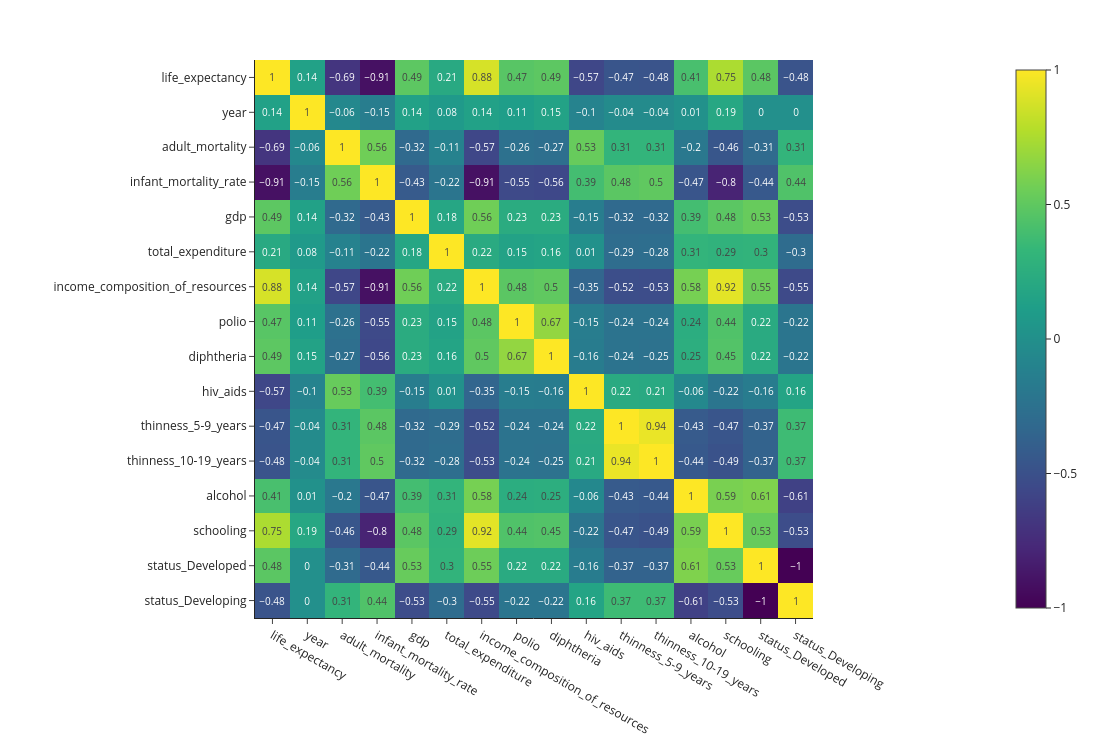

In [44]:
fig = px.imshow(corr_matrix.round(2), text_auto=True)
fig.update_layout(height=750, width=1100)
fig.show()

The new correlation matrix is very similar to the previous one before data imputation. The most notorious change is the correlation of feature `income_composition_of_resources` with the target `life_expectancy`, which increased from 0.72 to 0.88.

In [45]:
df_no_zeros = df[(df.loc[:, 'income_composition_of_resources'] > 0) & (df.loc[:, 'year'] < 2013)]
df_no_zeros['income_composition_of_resources'].corr(df_no_zeros['life_expectancy'])

0.8862661674489443

The increase in the correlation coefficient of `income_composition_of_resources`is due to the replacement of 0s that represented missing values with the imputated values.

# Data transformation

All features except `year` (needed as a timestamp), `income_composition_of_resources` (already has values between 0-1) and the `status` one-hot-encoded columns will be scaled. Features following a Gaussian distributions or with undefined range of values will be standardize; otherwise, normalized.

In [46]:
cols_standard = ['gdp', 'total_expenditure', 'alcohol', 'schooling']
cols_minmax = ['adult_mortality', 'infant_mortality_rate', 'polio', 'diphtheria', 'hiv_aids',
               'thinness_5-9_years', 'thinness_10-19_years']

In [47]:
# Standardization of features:
Xstd = RobustScaler()
Xstd.fit(df_train[cols_standard])
df_train[cols_standard] = Xstd.transform(df_train[cols_standard])
df_test[cols_standard] = Xstd.transform(df_test[cols_standard])

# Standardization of target:
ystd = RobustScaler()
ystd.fit(y_train.to_numpy().reshape(-1, 1))
y_train = ystd.transform(y_train.to_numpy().reshape(-1, 1)).ravel()
y_test = ystd.transform(y_test.to_numpy().reshape(-1, 1)).ravel()

# Normalization of features:
Xnorm = MinMaxScaler()
Xnorm.fit(df_train[cols_minmax])
df_train[cols_minmax] = Xnorm.transform(df_train[cols_minmax])
df_test[cols_minmax] = Xnorm.transform(df_test[cols_minmax])

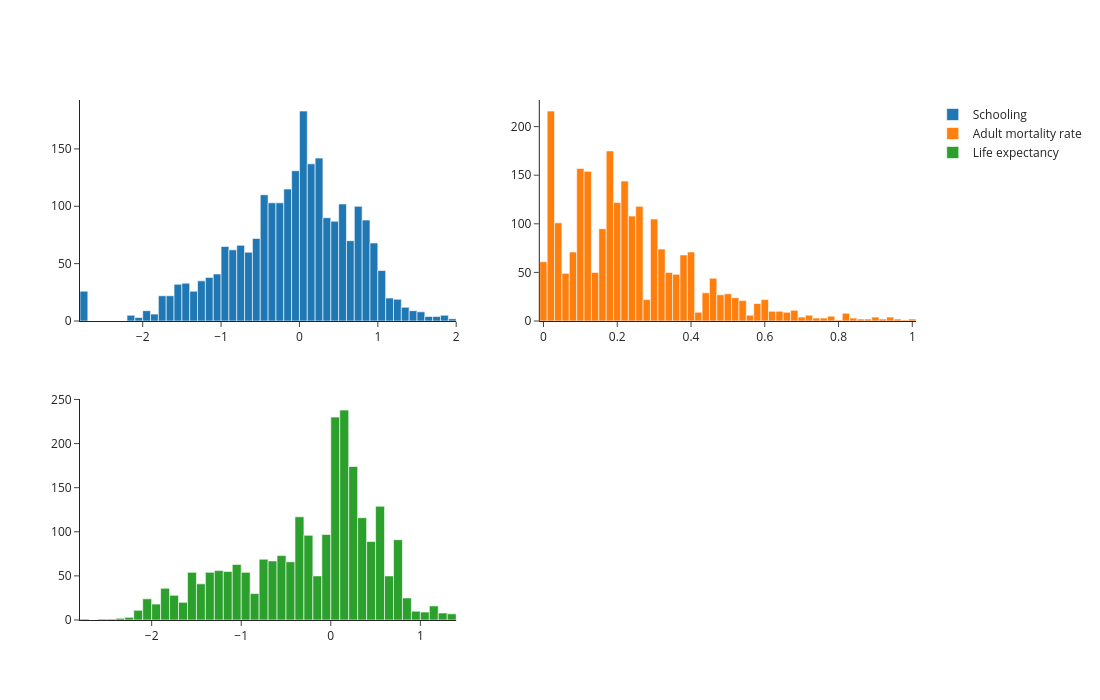

In [48]:
# Visualize a standardized (left) and a normalized feature (right),
# along with the standardized target (below):

fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Histogram(x=df_train['schooling'], name='Schooling'),
             row=1, col=1)
fig.add_trace(go.Histogram(x=df_train['adult_mortality'], name='Adult mortality rate'),
             row=1, col=2)
fig.add_trace(go.Histogram(x=y_train, name='Life expectancy'),
             row=2, col=1)

fig.update_layout(height=700, width=1100)
fig.show()

# Mutual information

In [49]:
mi_scores = mutual_info_regression(df_train, y_train)

df_mi = pd.DataFrame({
    'Feature': df_train.columns,
    'MI_score': mi_scores
}).sort_values(by='MI_score', ascending=False)

df_mi

,Feature,MI_score
1,adult_mortality,1.282804
2,infant_mortality_rate,1.069683
5,income_composition_of_resources,0.997191
9,thinness_5-9_years,0.843494
10,thinness_10-19_years,0.829114
12,schooling,0.690756
8,hiv_aids,0.525457
3,gdp,0.437925
11,alcohol,0.389215
6,polio,0.349552


MI scores indicate that adult and infant mortality rates best explain the target variable, which is expected. Features like `status`, `total_expenditure`, `diphtheria`, `polio`, `alcohol` and `gdp` could be dropped due to low MI scores. However, they could reasonably be informative during model training, specially `status`. Thus, I will proceed with all columns. In further iterations, features with low MI scores could be removed.

# Model training and hyperparameter tuning using rolling cross-validation

Since I'm working with a time series dataset, I cannot use standard cross-validation. Instead, I will use **TimeSeriesSplit** to preserve the temporal structure of the dataset during (rolling) cross-validation. Then, I will use **GridSearchCV** to assess the performance of different ML models and simoustaneously perform hyperparameter tunning, passing the splitting indexes retrived from TimeSeriesSplit.

In [50]:
# Setting the 'year' column as index for splitting in ascending order:
df_train = df_train.set_index('year')
years = np.sort(df_train.index.unique())

In [51]:
tscv = TimeSeriesSplit(4)
# Four splits results in an initial training dataset that includes the first four years of the timeseries (2000-2004)
# In each iteration, the training dataset is increased two years (up until 2010)
# The test dataset is always comprised of two years that follow the current training dataset

In [52]:
# Generate a list of indexes to split the time series dataset:
cv = []

for train_index, test_index in tscv.split(years):
    train_years, test_years = years[train_index], years[test_index]
    cv_train_index = np.where(df_train.index.isin(train_years))[0]
    cv_test_index = np.where(df_train.index.isin(test_years))[0]
    cv.append((cv_train_index, cv_test_index))

In [53]:
# Pipeline (with placeholder for model step)
pipe = Pipeline([
    ('model', None)
])

# Hyperparameters for different models:
params = [
    {
        'model': [SGDRegressor(max_iter=1000)],
        'model__alpha': [0.0001, 0.001, 0.01, 0.1],
        'model__penalty': ['l1', 'l2', 'elasticnet'],
        'model__eta0': [0.0001, 0.001, 0.01]
    },
    {
        'model': [HuberRegressor(max_iter=1000)],
        'model__epsilon': [1.2, 1.35, 1.5, 2],
        'model__alpha': [0.0001, 0.001, 0.01, 0.1]
    },
    {
        'model': [DecisionTreeRegressor(random_state=4)],
        'model__max_depth': [5, 8, 10, 15],
        'model__min_samples_leaf': [3, 5, 8, 10]
    },
    {
        'model': [RandomForestRegressor(random_state=4)],
        'model__max_depth': [5, 8, 10, 15],
        'model__min_samples_leaf': [3, 5, 8, 10],
        'model__n_estimators': [10, 50, 100, 150]
    },
    {
        'model': [XGBRegressor(random_state=4)],
        'model__max_depth': [5, 8, 10, 15],
        'model__n_estimators': [10, 50, 100, 150],
        'model__eta': [0.3, 0.1]
    },
    {
        'model': [SVR()],
        'model__kernel': ['linear', 'rbf'],
        'model__C': [0.1, 1, 5, 15],
        'model__epsilon': [0.01, 0.1, 0.5, 1.0]
    }
]

In [54]:
# Cross-validation and hyperparameter tuning:
scoring_metric = 'neg_mean_squared_error'
grid = GridSearchCV(pipe, params, cv=cv, scoring=scoring_metric)
result = grid.fit(df_train, y_train)

In [78]:
# Save results in a dataframe:
df_cv = pd.concat([pd.DataFrame(grid.cv_results_['params']),
                   pd.DataFrame(grid.cv_results_['mean_test_score'], columns=['MSE']),
                   pd.DataFrame(grid.cv_results_['mean_fit_time'], columns=['mean_fit_time']),
                   pd.DataFrame(grid.cv_results_['mean_score_time'], columns=['mean_score_time'])],
                  axis=1)
df_cv['model_name'] = df_cv.model.astype(str).str.split('(').str[0]

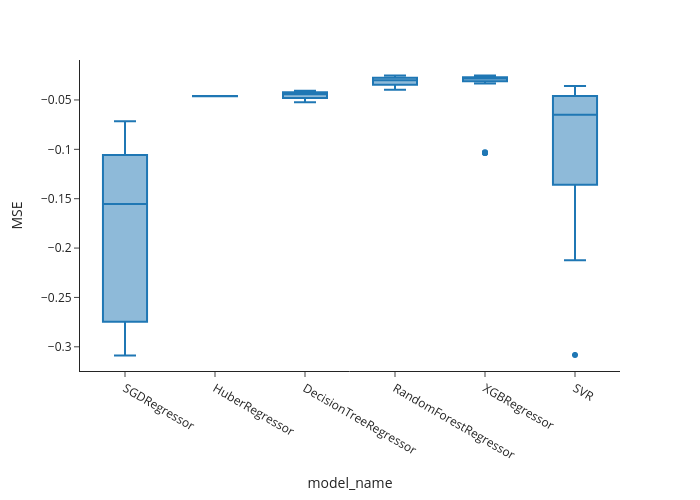

In [71]:
# Boxplots of MSE:
fig = px.box(df_cv, x='model_name', y='MSE')
fig.show()

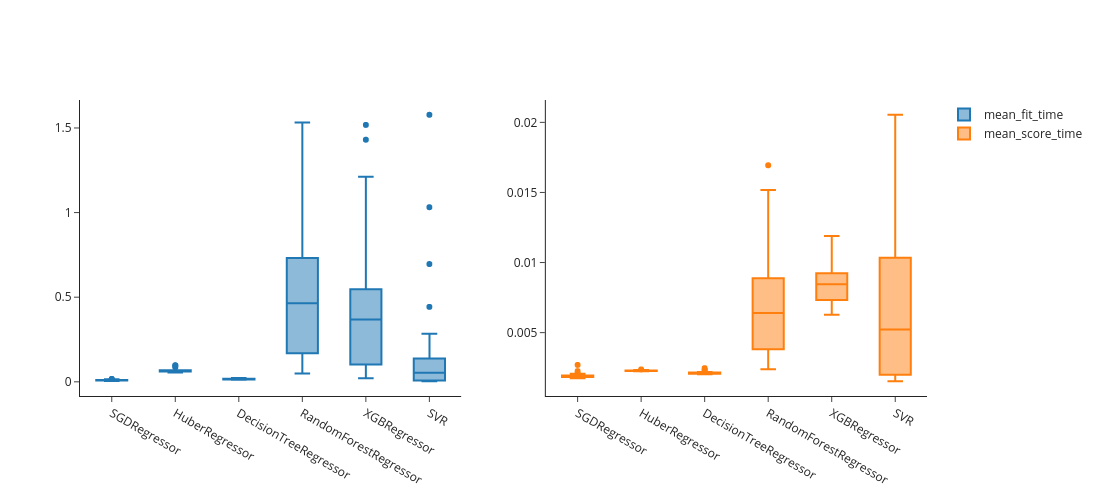

In [81]:
# Boxplots for the mean fitting and scoring times:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Box(x=df_cv['model_name'], y=df_cv['mean_fit_time'], name='mean_fit_time'),
             row=1, col=1)
fig.add_trace(go.Box(x=df_cv['model_name'], y=df_cv['mean_score_time'], name='mean_score_time'),
             row=1, col=2)

fig.update_layout(height=500, width=1100)
fig.show()

In [88]:
# The best overall model:
df_cv.iloc[grid.best_index_]

model                      RandomForestRegressor(random_state=4)
model__alpha                                                 NaN
model__eta0                                                  NaN
model__penalty                                               NaN
model__epsilon                                               NaN
model__max_depth                                            15.0
model__min_samples_leaf                                      3.0
model__n_estimators                                        150.0
model__eta                                                   NaN
model__C                                                     NaN
model__kernel                                                NaN
MSE                                                    -0.025277
mean_fit_time                                           1.254669
mean_score_time                                         0.012848
model_name                                 RandomForestRegressor
Name: 119, dtype: object

In [91]:
# The best SGDRegressor hyperparameters:
df_cv_SGD = df_cv.loc[df_cv.loc[:, 'model_name'] == 'SGDRegressor']
df_cv_SGD[df_cv_SGD.MSE == df_cv_SGD.MSE.min()].iloc[0]

model                      SGDRegressor()
model__alpha                          0.1
model__eta0                        0.0001
model__penalty                         l1
model__epsilon                        NaN
model__max_depth                      NaN
model__min_samples_leaf               NaN
model__n_estimators                   NaN
model__eta                            NaN
model__C                              NaN
model__kernel                         NaN
MSE                             -0.308758
mean_fit_time                    0.016209
mean_score_time                  0.001876
model_name                   SGDRegressor
Name: 27, dtype: object

Although the **Random Forest** algorithm generated the best model (MSE = -0.025), it was also complex (150 estimators) and one of the slowest models to train and make predictions. In a production environment with larger datasets or real-time requirements, this complexity could lead to scalability issues and degraded performance. Moreover, given the strong correlations observed between several features and the target variable (see previous sections), the use of a Random Forest may be unnecessarily complex, especially when simpler models, like linear regression (see SGDRegressor and HuberRegressor), could provide comparable performance with less computational overhead.

The **SGDRegressor** algorithm (that implements a linear regression model optimized by stochastic gradient descent), although not that precise (MSE = -0.31), is fast, simple and has the added advantage of supporting incremental learning, enabling continous model updates with new upcoming data.